In [1]:
# model 1 把所有normalize換成 batch normalize, 所有nonlinear 換成leaky relu, 在fpn最前面加入norm並且在所有相加的部分前加入norm
import torch
import cv2
import os
import numpy as np
import shutil
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import math
from PIL import Image
import torch.nn as nn
import yaml
import random
from google.colab import files
import sys
import time
from torch.utils.data import random_split
device = "cuda" if torch.cuda.is_available() else "cpu" # 檢查是否有可用的 CUDA 設備（通常是顯卡，支援 GPU 運算），如果有，就將 device 變數設置為 "cuda"，否則設置為 "cpu"。

In [2]:
def deb(param, str):
  print(str + " = {}".format(param))

In [3]:
def load_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

In [4]:
def count_params(model):
  sum = 0
  for param in model.parameters():
    sum = sum + param.numel()
  return sum

In [5]:
file_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Model/config.yml'
config = load_config(file_path)

In [6]:
target_size = (config['data']['image_size'], config['data']['image_size'])

In [7]:
# develop
# image_path = "/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test/raw_data"
# depth_path = "/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test/train"
# image_file = sorted(os.listdir(image_path))
# depth_file = sorted(os.listdir(depth_path))

In [8]:
'''
def find_next_file(first, second):
  first_list = sorted(os.listdir(first))
  second_list = sorted(os.listdir(second))
  length = len(first_list)
  while True:
    rand_int = random.randint(0, length - 1)
    target = first_list[rand_int]
    if target in second_list:
      return first + '/' + target, second + '/' + target
'''

"\ndef find_next_file(first, second):\n  first_list = sorted(os.listdir(first))\n  second_list = sorted(os.listdir(second))\n  length = len(first_list)\n  while True:\n    rand_int = random.randint(0, length - 1)\n    target = first_list[rand_int]\n    if target in second_list:\n      return first + '/' + target, second + '/' + target\n"

In [9]:
def find_next_file(first, second):
  first_list = sorted(os.listdir(first))
  second_list = sorted(os.listdir(second))
  length = len(first_list)
  while True:
    rand_int = random.randint(0, length - 1)
    target = first_list[rand_int]
    if target in second_list:
      return first + '/' + target, second + '/' + target


In [10]:
def create_dataset_save(first_path, second_path, epoch_size = 5000): # first is depth, second is image
  depth_list = []
  image_list = []
  depth_name_list = []
  image_name_list = []
  count = 0
  file_count = 1

  first_path_list1 = sorted(os.listdir(first_path))
  second_path_list1 = sorted(os.listdir(second_path))
  for first_seg1 in first_path_list1:
    '''
    if first_seq1 == '2011_09_30_drive_0028_sync':
      return
    '''
    first_path2 = first_path + '/' + first_seg1 + '/proj_depth/groundtruth/'
    second_path2 = second_path + '/' + first_seg1 + '/'
    first_path_list2 = sorted(os.listdir(first_path2))
    for first_seg2 in first_path_list2: # image02, image03
      first_path3 = first_path2 + first_seg2 + '/'
      second_path3 = second_path2 + first_seg2 + '/data/'
      first_path_list3 = sorted(os.listdir(first_path3))
      for first_seq3 in first_path_list3:
        first_path4 = first_path3 + first_seq3
        second_path4 = second_path3 + first_seq3
        depth = np.array(Image.open(file_path), dtype=np.int16)
        depth = cv2.resize(depth, target_size, cv2.INTER_LANCZOS4)
        depth = depth.astype(np.float16) / 256.0
        # depth = cv2.imread(first_path4)
        image = cv2.imread(second_path4)
        # depth = cv2.resize(depth, target_size, interpolation = cv2.INTER_LANCZOS4)
        image = cv2.resize(image, target_size, interpolation = cv2.INTER_LANCZOS4)
        depth_list.append(depth)
        depth_name_list.append(first_path4)
        image_list.append(image)
        image_name_list.append(second_path4)
        count = count + 1
        if count == epoch_size:
          count = 0
          checkpoint = {
              'depth_list': depth_list,
              'image_list' : image_list,
          }
          checkpoint2 = {
              'depth_name' : depth_name_list,
              'image_name' : image_name_list
          }
          name = 'dataset_{}'.format(file_count)
          name2 = 'name_list_{}'.format(file_count)
          file_count = file_count + 1
          torch.save(checkpoint, name)
          torch.save(checkpoint2, name2)
          source_path = name
          source_path2 = name2
          destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip'    # 要改
          destination_path2 = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip'

          shutil.copy(source_path, destination_path)
          shutil.copy(source_path2, destination_path2)

          depth_name_list = []
          image_name_list = []
          depth_list = []
          image_list = []



In [16]:
# dev
def create_dataset_save(first_path, second_path, epoch_size = 5000): # first is depth, second is image
  depth_list = []
  image_list = []
  depth_name_list = []
  image_name_list = []
  count = 0
  file_count = 14  #改

  first_path_list1 = sorted(os.listdir(first_path))
  second_path_list1 = sorted(os.listdir(second_path))
  idx1_start = 134   #改

  for idx1 in range(idx1_start, len(first_path_list1)):

    first_seq1 = first_path_list1[idx1]
    # if first_seq1 == '2011_09_28_drive_0090_sync': #改
    #   continue
    first_path2 = first_path + '/' + first_seq1 + '/proj_depth/groundtruth'
    second_path2 = second_path + '/' + first_seq1
    first_path_list2 = sorted(os.listdir(first_path2))

    if idx1 == idx1_start:
      idx2_start = 1  # 改
    else:
      idx2_start = 0
    for idx2 in range(idx2_start, len(first_path_list2)): # image02, image03
      first_seq2 = first_path_list2[idx2]
      first_path3 = first_path2 + '/' + first_seq2
      second_path3 = second_path2 + '/' + first_seq2 + '/data'
      first_path_list3 = sorted(os.listdir(first_path3))
      if idx1 == idx1_start and idx2 == idx2_start:
        idx3_start = 1010 #改成+1
      else:
        idx3_start = 0
      for idx3 in range(idx3_start, len(first_path_list3)):
        first_seq3 = first_path_list3[idx3]
        first_path4 = first_path3 + '/' + first_seq3
        second_path4 = second_path3 + '/' + first_seq3
        print(count)
        print(first_path4)
        print(second_path4)
        if first_path4[-5] == ')':
          continue
        depth = np.array(Image.open(first_path4), dtype=np.int16)
        depth = cv2.resize(depth, target_size, cv2.INTER_LANCZOS4)
        depth = depth.astype(np.float16) / 256.0

        # depth = cv2.imread(first_path4)
        image = cv2.imread(second_path4)
        # depth = cv2.resize(depth, target_size, interpolation = cv2.INTER_LANCZOS4)

        image = cv2.resize(image, target_size, interpolation = cv2.INTER_LANCZOS4)
        depth_list.append(depth)
        depth_name_list.append(first_path4)
        image_list.append(image)
        image_name_list.append(second_path4)
        count = count + 1
        # if (count % 1000 == 0):

        if count == epoch_size:
          count = 0
          checkpoint = {
              'depth_list': depth_list,
              'image_list' : image_list,
          }
          checkpoint2 = {
              'depth_name' : depth_name_list,
              'image_name' : image_name_list
          }
          name = 'dataset_{}.pth'.format(file_count)
          name2 = 'name_list_{}.pth'.format(file_count)
          file_count = file_count + 1
          torch.save(checkpoint, name)
          torch.save(checkpoint2, name2)
          source_path = name
          source_path2 = name2
          destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip'    # 要改
          destination_path2 = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip'

          shutil.copy(source_path, destination_path)
          shutil.copy(source_path2, destination_path2)

          depth_name_list = []
          image_name_list = []
          depth_list = []
          image_list = []



In [ ]:
first_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth'
second_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image'
create_dataset_save(first_path, second_path, epoch_size = 5000) # first is depth, second is image

from google.colab import runtime
runtime.unassign()

串流輸出內容已截斷至最後 5000 行。
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_10_03_drive_0042_sync/proj_depth/groundtruth/image_02/0000000658.png
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image/2011_10_03_drive_0042_sync/image_02/data/0000000658.png
4232
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_10_03_drive_0042_sync/proj_depth/groundtruth/image_02/0000000659.png
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image/2011_10_03_drive_0042_sync/image_02/data/0000000659.png
4233
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_10_03_drive_0042_sync/proj_depth/groundtruth/image_02/0000000660.png
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image/2011_10_03_drive_0042_sync/image_02/data/0000000660.png
4234
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_10_03_drive_0042_sync/proj_depth/groundtruth/image_02/0000000661.png
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image/2011_10_03_drive_004

In [ ]:

dataset_check = torch.load('/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip/dataset_0.pth')
name_check = torch.load('/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip/name_list_0.pth')
dataset_check.keys()

dict_keys(['depth_list', 'image_list'])

In [ ]:
compare_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/0000000005.png'
compare_depth = np.array(Image.open(compare_path), dtype=np.int16)
image = dataset_check['image_list'][0]
compare_depth = cv2.resize(compare_depth, target_size, cv2.INTER_LANCZOS4)
compare_depth = compare_depth.astype(np.float16) / 256.0
image.dtype

dtype('uint8')

In [ ]:
path = name_check['depth_name'][0]
depth = dataset_check['depth_list'][0]
print(depth.max())
print(compare_depth.max())
print(depth.dtype)
print(compare_depth.dtype)
print(depth.shape)
print(compare_depth.shape)
print(np.array_equal(depth, compare_depth))

78.9
78.9
float16
float16
(256, 256)
(256, 256)
True


In [12]:
debug_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip/name_list_13.pth'
check = torch.load(debug_path)
print(check['depth_name'][4999])

/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_09_30_drive_0034_sync/proj_depth/groundtruth/image_03/0000001014.png


In [ ]:

image_name_list = checkpoint['depth_name']
depth_name_list = checkpoint['depth_name']


In [ ]:

depth_name_list[4999]
# 2011_09_26_drive_0087_sync : 28
# image_03 : 1
# 0000000695.png ; 690

# /content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_09_26_drive_0087_sync/proj_depth/groundtruth/image_03/0000000695.png


'/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_09_28_drive_0057_sync/proj_depth/groundtruth/image_03/0000000036.png'

In [13]:

path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_09_30_drive_0034_sync/proj_depth/groundtruth/image_03'
file = sorted(os.listdir(path))
for idx in range(len(file)):
  if file[idx] == '0000001014.png':
    print(idx)


1009


In [14]:

path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_09_30_drive_0034_sync/proj_depth/groundtruth'
file = sorted(os.listdir(path))
for idx in range(len(file)):
  if file[idx] == 'image_03':
    print(idx)


1


In [15]:
path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth'
file = sorted(os.listdir(path))
for idx in range(len(file)):
  if file[idx] == '2011_09_30_drive_0034_sync':
    print(idx)

134


In [ ]:
# first_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth'
# second_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image'
# create_dataset_save(first_path, second_path, epoch_size = 5000) # first is depth, second is image

# from google.colab import runtime
# runtime.unassign()

串流輸出內容已截斷至最後 5000 行。
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_10_03_drive_0042_sync/proj_depth/groundtruth/image_02/0000000658.png
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image/2011_10_03_drive_0042_sync/image_02/data/0000000658.png
4232
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_10_03_drive_0042_sync/proj_depth/groundtruth/image_02/0000000659.png
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image/2011_10_03_drive_0042_sync/image_02/data/0000000659.png
4233
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_10_03_drive_0042_sync/proj_depth/groundtruth/image_02/0000000660.png
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image/2011_10_03_drive_0042_sync/image_02/data/0000000660.png
4234
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_10_03_drive_0042_sync/proj_depth/groundtruth/image_02/0000000661.png
/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image/2011_10_03_drive_004

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image/2011_09_28_drive_0090_sync/image_02/data/0000000005.png')
print(type(test_img))
cv2_imshow(test_img)

<class 'NoneType'>


AttributeError: 'NoneType' object has no attribute 'clip'

In [ ]:
# test_string = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image/2011_09_26_drive_0104_sync/image_02/data/0000000059 (1).png'
# test_string[-5] == ')'

True

In [ ]:
test_img1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/0000000005.png')
test_img2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_03/0000000005.png')

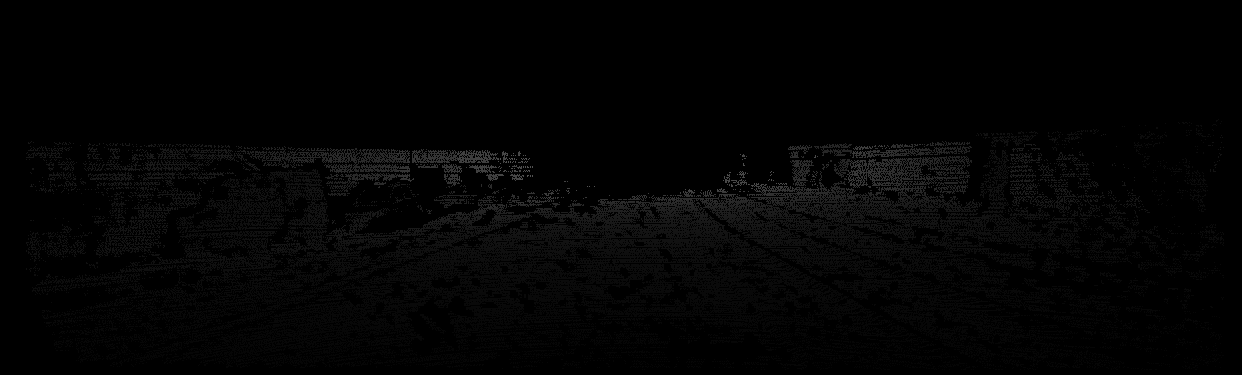

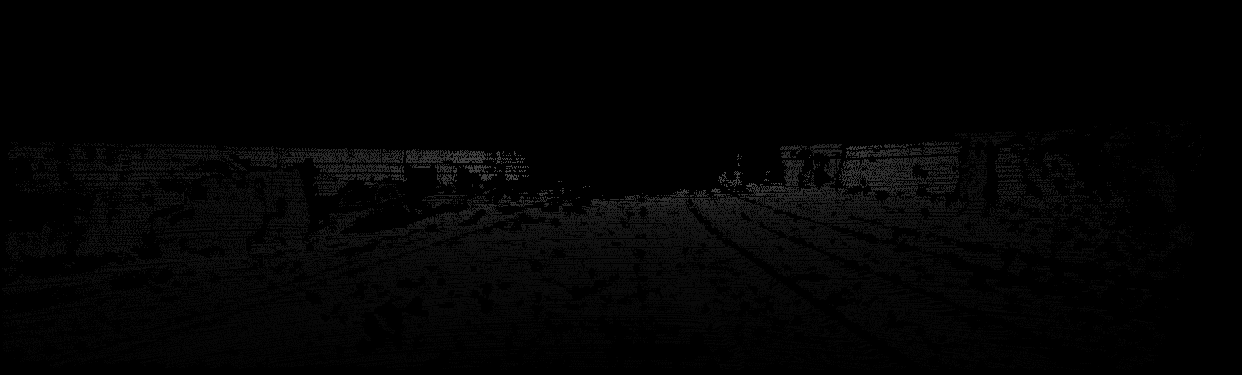

In [ ]:
cv2_imshow(test_img1)
cv2_imshow(test_img2)

In [ ]:
comp = test_img1 == test_img2
# print(comp)
comp.shape
false_count = 0
for idx in range(comp.shape[0]):
  for jdx in range(comp.shape[1]):
    for zdx in range(comp.shape[2]):
      if comp[idx][jdx][zdx] == False:
        print(idx, jdx, zdx)

串流輸出內容已截斷至最後 5000 行。
143 49 0
143 49 1
143 49 2
143 54 0
143 54 1
143 54 2
143 55 0
143 55 1
143 55 2
143 56 0
143 56 1
143 56 2
143 59 0
143 59 1
143 59 2
143 60 0
143 60 1
143 60 2
143 62 0
143 62 1
143 62 2
143 63 0
143 63 1
143 63 2
143 65 0
143 65 1
143 65 2
143 66 0
143 66 1
143 66 2
143 70 0
143 70 1
143 70 2
143 73 0
143 73 1
143 73 2
143 84 0
143 84 1
143 84 2
143 88 0
143 88 1
143 88 2
143 89 0
143 89 1
143 89 2
143 95 0
143 95 1
143 95 2
143 98 0
143 98 1
143 98 2
143 99 0
143 99 1
143 99 2
143 102 0
143 102 1
143 102 2
143 110 0
143 110 1
143 110 2
143 113 0
143 113 1
143 113 2
143 117 0
143 117 1
143 117 2
143 122 0
143 122 1
143 122 2
143 125 0
143 125 1
143 125 2
143 129 0
143 129 1
143 129 2
143 845 0
143 845 1
143 845 2
143 919 0
143 919 1
143 919 2
143 922 0
143 922 1
143 922 2
143 923 0
143 923 1
143 923 2
143 925 0
143 925 1
143 925 2
143 927 0
143 927 1
143 927 2
143 928 0
143 928 1
143 928 2
143 929 0
143 929 1
143 929 2
143 930 0
143 930 1
143 930 2
143 931 0
143

KeyboardInterrupt: 

In [ ]:
test_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth/2011_09_26_drive_0093_sync/proj_depth/groundtruth/image_02'
test_list = sorted(os.listdir(test_path))
test_list

['0000000005.png',
 '0000000006.png',
 '0000000007.png',
 '0000000008.png',
 '0000000009.png',
 '0000000010.png',
 '0000000011.png',
 '0000000012.png',
 '0000000013.png',
 '0000000014.png',
 '0000000015.png',
 '0000000016.png',
 '0000000017.png',
 '0000000018.png',
 '0000000019.png',
 '0000000020.png',
 '0000000021.png',
 '0000000022.png',
 '0000000023.png',
 '0000000024.png',
 '0000000025.png',
 '0000000026.png',
 '0000000027.png',
 '0000000028.png',
 '0000000029.png',
 '0000000030.png',
 '0000000031.png',
 '0000000032.png',
 '0000000033.png',
 '0000000034.png',
 '0000000035.png',
 '0000000036.png',
 '0000000037.png',
 '0000000038.png',
 '0000000039.png',
 '0000000040.png',
 '0000000041.png',
 '0000000042.png',
 '0000000043.png',
 '0000000044.png',
 '0000000045.png',
 '0000000046.png',
 '0000000047.png',
 '0000000048.png',
 '0000000049.png',
 '0000000050.png',
 '0000000051.png',
 '0000000052.png',
 '0000000053.png',
 '0000000054.png',
 '0000000055.png',
 '0000000056.png',
 '0000000057

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Image/2011_09_26_drive_0093_sync/image_02/data/0000000097 (1).png')

In [ ]:
cv2_imshow(test_img)

AttributeError: 'NoneType' object has no attribute 'clip'

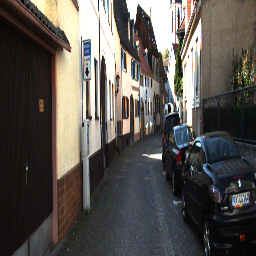

In [ ]:
test_img_resize = cv2.resize(test_img, target_size, interpolation = cv2.INTER_LANCZOS4)
cv2_imshow(test_img_resize)

In [ ]:
'''
import shutil
for idx in range(2, 5):
  depth_list, image_list = create_dataset_save(1000, depth_path, image_path)
  checkpoint = {
            'depth_list': depth_list,
            'image_list' : image_list,
          }
  name = 'test_list_file{}.pth'.format(idx)
  torch.save(checkpoint, name)
  del depth_list, image_list
  source_path = name
  destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test'


  # save them to the google drive
  shutil.copy(source_path, destination_path)
'''

"\nimport shutil\nfor idx in range(2, 5):\n  depth_list, image_list = create_dataset_save(1000, depth_path, image_path)\n  checkpoint = {\n            'depth_list': depth_list,\n            'image_list' : image_list,\n          }\n  name = 'test_list_file{}.pth'.format(idx)\n  torch.save(checkpoint, name)\n  del depth_list, image_list\n  source_path = name\n  destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test'\n\n\n  # save them to the google drive\n  shutil.copy(source_path, destination_path)\n"

In [ ]:
def create_dataset(data_per_epoch, amount_from_file, path): #data_per_epoch / amount_from_file要是整數

  name_list = sorted(os.listdir(path))

  if data_per_epoch % amount_from_file != 0:
    print("error, data_per_epoch can't divide amount_from_file !!!!!")
    sys.exit(1)

  file_idx = data_per_epoch // amount_from_file

  output_depth = []
  output_image = []
  length = len(name_list)
  for idx in range(file_idx):
    rand_int = random.randint(0, length - 1)
    tmp_file = name_list[rand_int]
    name = path + '/' + tmp_file
    checkpoint = torch.load(name)
    depth_list = checkpoint['depth_list']
    image_list = checkpoint['image_list']
    length_inside = len(depth_list)
    random_number = torch.randint(0, length_inside, (amount_from_file, ))

    for jdx in range(amount_from_file):

      output_depth.append(depth_list[random_number[jdx]])
      output_image.append(image_list[random_number[jdx]])
  return output_image, output_depth



In [ ]:
def create_dataset_for_debug(data_per_epoch, amount_from_file, path): #data_per_epoch / amount_from_file要是整數
  name_list = sorted(os.listdir(path))
  file_idx = data_per_epoch // amount_from_file
  output_depth_path = []
  output_image_path = []
  output_depth = []
  output_image = []
  sym = 0
  if data_per_epoch % amount_from_file  != 0:
    file_idx = file_idx + 1
    sym = 1
  length = len(name_list)
  for idx in range(file_idx):
    rand_int = random.randint(0, length - 1)
    tmp_file = name_list[rand_int]
    name = path + '/' + tmp_file
    checkpoint = torch.load(name)
    depth_list = checkpoint['depth_list']
    image_list = checkpoint['image_list']
    length_inside = len(depth_list)
    if sym == 1:
      if idx == file_idx - 1:

        random_number = torch.randint(0, length_inside, ((data_per_epoch % amount_from_file), ))
      else:

        random_number = torch.randint(0, length_inside, (amount_from_file, ))


    else:
      random_number = torch.randint(0, length_inside, (amount_from_file, ))
    for jdx in range(amount_from_file):

      output_depth.append(depth_list[random_number[jdx]])
      output_image.append(image_list[random_number[jdx]])
  return output_image, output_depth



In [ ]:
def create_dataset_large_epoch(random_list, now, data_path, name_path): #data_per_epoch / amount_from_file要是整數

  data_list = sorted(os.listdir(data_path))


  # file_idx = data_per_epoch // amount_from_file
  output_depth_path = []
  output_image_path = []
  output_depth = []
  output_image = []

  now_number = random_list[now]
  data_path = data_path + '/' + data_list[now_number]
  name_path = name_path + '/' + data_list[now_number]
  data_checkpoint = torch.load(data_path)
  name_checkpoint = torch.load(name_path)
  output_image_path = name_checkpoint['image_name']
  output_depth_path = name_checkpoint['depth_name']
  output_depth = data_checkpoint['depth_list']
  output_image = data_checkpoint['image_list']
  return output_image_path, output_depth_path, output_depth, output_image

In [ ]:
random_list = []
for idx in range(5):
  random_list.append(idx)
random.shuffle(random_list)
now = 2 # 實際上now也要從0一路走到最大值
data_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/data_zip'
name_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/name_zip'

output_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)

In [ ]:
output_image_test = output_image[0:1]
output_depth_test = output_depth[0:1]
output_depth_path[0]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img, depth):
        self.img = img
        self.depth = depth


    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        sample = {'img': self.img[idx], 'depth': self.depth[idx]}
        return sample


In [ ]:
custom_dataset = CustomDataset(output_image_test, output_depth_test)
batch_size = 1
trainloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def image_loader_to_tensor(tensor):
  tensor = tensor.to(torch.float32)
  tensor = tensor / 255.0
  tensor = tensor * 2.0
  tensor = tensor - 1.0
  tensor = tensor.permute(0, 3, 1, 2)
  return tensor

In [ ]:
'''
image, depth = create_dataset(10000, 1000, '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test/test_list_file')
'''

"\nimage, depth = create_dataset(10000, 1000, '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test/test_list_file')\n"

In [ ]:
'''
for idx in range(20):
  cv2_imshow(image[idx])
'''

'\nfor idx in range(20):\n  cv2_imshow(image[idx])\n'

In [ ]:
'''
import shutil
source_path = 'test_list_file.pth'
destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test'


# save them to the google drive
shutil.copy(source_path, destination_path)
'''

"\nimport shutil\nsource_path = 'test_list_file.pth'\ndestination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test'\n\n\n# save them to the google drive\nshutil.copy(source_path, destination_path)\n"

In [ ]:
'''
load_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test/test_list_file.pth' # 位置要改
checkpoint = torch.load(load_path)
depth_list = checkpoint['depth_list']
image_list = checkpoint['image_list']
'''

"\nload_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test/test_list_file.pth' # 位置要改\ncheckpoint = torch.load(load_path)\ndepth_list = checkpoint['depth_list']\nimage_list = checkpoint['image_list']\n"

In [ ]:
# len(image_list)

In [ ]:
# import json

# with open('test_list_file.txt', 'w') as file:
#   for item in image_list:
#     file.write(f"{item}\n")

In [ ]:
# with open('test_list_file.txt', 'r') as file:
#   for line in file.readlines():
#     load_list = line.strip()
#     print(load_list)
#     break

In [ ]:
'''
first, second = find_next_file(depth_path, image_path)
first = first + '/proj_depth/groundtruth'
first, second = find_next_file(first, second)
second = second + '/data'
first, second = find_next_file(first, second)
print(first)
print(second)
first_dep = cv2.imread(first)
second_img = cv2.imread(second)
cv2_imshow(first_dep )
cv2_imshow(second_img)
'''

"\nfirst, second = find_next_file(depth_path, image_path)\nfirst = first + '/proj_depth/groundtruth'\nfirst, second = find_next_file(first, second)\nsecond = second + '/data'\nfirst, second = find_next_file(first, second)\nprint(first)\nprint(second)\nfirst_dep = cv2.imread(first)\nsecond_img = cv2.imread(second)\ncv2_imshow(first_dep )\ncv2_imshow(second_img)\n"

In [ ]:
'''
# first == '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/0000000006.png'
first == '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_03/0000000006.png'
# first
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth_Sample/2011_09_26_drive_0002_sync_groundtruth_depth_0000000005_image_02.png')
cv2_imshow(img)
'''

"\n# first == '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/0000000006.png'\nfirst == '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data_test/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_03/0000000006.png'\n# first\nimg = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/Depth_Sample/2011_09_26_drive_0002_sync_groundtruth_depth_0000000005_image_02.png')\ncv2_imshow(img)\n"

In [ ]:
'''
# develop
batch_size = 4
print(image_file)
print(depth_file)
count = 0
while count < batch_size:
  image_whole = image_path
  depth_whole = depth_path


  rand_int = random.randint(0, len(image_file) - 1)
  print(rand_int)
  target = depth_file[rand_int]
  print(target)
  if target in image_file:
    # print("exist")
    image_whole = image_whole + '/' + depth_file[rand_int]
    depth_whole = depth_whole + '/' + depth_file[rand_int] + '/proj_depth/groundtruth'
    print(image_whole)
    print(depth_whole)
    count = count + 1
  else:
    print("not exist")

    # print(image_path + '/' + image_file[rand_int])
    # print(depth_path + '/' + depth_file[rand_int])
  # rand_int = torch.randint(0, 2, (batch_size,))
  # print(rand_int)
  # print(image_path + '/' + image_file[0])
  # for idx in rand_int:
  #   print(idx)
  #   print(image_file[rand_int[idx]])
'''

'\n# develop\nbatch_size = 4\nprint(image_file)\nprint(depth_file)\ncount = 0\nwhile count < batch_size:\n  image_whole = image_path\n  depth_whole = depth_path\n\n\n  rand_int = random.randint(0, len(image_file) - 1)\n  print(rand_int)\n  target = depth_file[rand_int]\n  print(target)\n  if target in image_file:\n    # print("exist")\n    image_whole = image_whole + \'/\' + depth_file[rand_int]\n    depth_whole = depth_whole + \'/\' + depth_file[rand_int] + \'/proj_depth/groundtruth\'\n    print(image_whole)\n    print(depth_whole)\n    count = count + 1\n  else:\n    print("not exist")\n\n    # print(image_path + \'/\' + image_file[rand_int])\n    # print(depth_path + \'/\' + depth_file[rand_int])\n  # rand_int = torch.randint(0, 2, (batch_size,))\n  # print(rand_int)\n  # print(image_path + \'/\' + image_file[0])\n  # for idx in rand_int:\n  #   print(idx)\n  #   print(image_file[rand_int[idx]])\n'

In [ ]:
def image_folder_to_tensor(folder_path):

    images_list = []


    files = sorted(os.listdir(folder_path))

    for file in files:

        file_path = os.path.join(folder_path, file)

        img = cv2.imread(file_path)
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_LANCZOS4)
        images_list.append(img)

    img2 = np.stack(images_list, axis=0)
    tensor = torch.tensor(img2)
    tensor = tensor.to(torch.float16)
    tensor = tensor / 255.0
    tensor = tensor * 2.0
    tensor = tensor - 1.0
    tensor = tensor.permute(0, 3, 1, 2)

    return tensor




In [ ]:
def image_tensor_to_numpy(tensor):

    tensor = tensor.permute(0, 2, 3, 1)
    output = tensor.numpy()
    output = output + 1.0
    output = output / 2.0
    output = output * 255.0
    output = output.astype(np.uint8)

    return output

In [ ]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/image"

img = image_folder_to_tensor(folder_path)
img.shape

torch.Size([1000, 3, 256, 256])

In [ ]:
# this is min max normalize
'''
def depth_folder_to_tensor(folder_path):

    images_list = []



    files = sorted(os.listdir(folder_path))

    for file in files:

        file_path = os.path.join(folder_path, file)
        depth = np.array(Image.open(file_path), dtype=np.int16)
        assert(np.max(depth) > 255)
        depth = cv2.resize(depth, target_size, cv2.INTER_LANCZOS4)
        depth = depth.astype(np.float16) / 256.0
        images_list.append(depth)



    img2 = np.stack(images_list, axis=0)
    tensor = torch.tensor(img2)

    mini = torch.min(tensor[tensor != 0])
    tensor = (tensor - mini) / (tensor.max() - mini)
    tensor = torch.where(tensor < 0, -1, tensor)






    return tensor
'''

'\ndef depth_folder_to_tensor(folder_path):\n\n    images_list = []\n\n\n\n    files = sorted(os.listdir(folder_path))\n\n    for file in files:\n\n        file_path = os.path.join(folder_path, file)\n        depth = np.array(Image.open(file_path), dtype=np.int16)\n        assert(np.max(depth) > 255)\n        depth = cv2.resize(depth, target_size, cv2.INTER_LANCZOS4)\n        depth = depth.astype(np.float16) / 256.0\n        images_list.append(depth)\n\n\n\n    img2 = np.stack(images_list, axis=0)\n    tensor = torch.tensor(img2)\n\n    mini = torch.min(tensor[tensor != 0])\n    tensor = (tensor - mini) / (tensor.max() - mini)\n    tensor = torch.where(tensor < 0, -1, tensor)\n\n\n\n\n\n\n    return tensor\n'

In [ ]:
# this is z-score normalization

def depth_folder_to_tensor(folder_path):

    images_list = []



    files = sorted(os.listdir(folder_path))

    for file in files:

        file_path = os.path.join(folder_path, file)
        depth = np.array(Image.open(file_path), dtype=np.int16)
        assert(np.max(depth) > 255)
        depth = cv2.resize(depth, target_size, cv2.INTER_LANCZOS4)
        depth = depth.astype(np.float16) / 256.0
        images_list.append(depth)



    img2 = np.stack(images_list, axis=0)
    tensor = torch.tensor(img2)
    nonzero_mask = tensor != 0
    zero_mask = tensor == 0
    mean = tensor[nonzero_mask].mean()
    std = tensor[nonzero_mask].std()
    result = (tensor[nonzero_mask] - mean) / std
    tensor[nonzero_mask] = result
    tensor[zero_mask] = -1



    return tensor, mean, std

In [ ]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/groundtruth_depth"
dep, depth_mean, depth_std = depth_folder_to_tensor(folder_path)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img, depth):
        self.img = img
        self.depth = depth

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        sample = {'img': self.img[idx], 'depth': self.depth[idx]}
        return sample





custom_dataset = CustomDataset(img, dep)


batch_size = 2
trainloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# filename = "/content/drive/MyDrive/Colab Notebooks/Simple_DE/groundtruth_depth/2011_09_26_drive_0002_sync_groundtruth_depth_0000000005_image_02.png"
# def depth_read(filename):

#     depth_png = np.array(Image.open(filename), dtype=int)

#     assert(np.max(depth_png) > 255)

#     depth = depth_png.astype(np.float32) / 256.
#     depth[depth_png == 0] = -1.
#     return depth



In [ ]:
def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    def sigmoid(x):
        return 1 / (np.exp(-x) + 1)

    if beta_schedule == "quad":
        betas = (
            np.linspace(
                beta_start ** 0.5,
                beta_end ** 0.5,
                num_diffusion_timesteps,
                dtype=np.float64,
            )
            ** 2
        )
    elif beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1.0 / np.linspace(
            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "sigmoid":
        betas = np.linspace(-6, 6, num_diffusion_timesteps)
        betas = sigmoid(betas) * (beta_end - beta_start) + beta_start
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas

In [ ]:
# beta = torch.tensor(get_beta_schedule(beta_schedule, beta_start = beta_start, beta_end = beta_end, num_diffusion_timesteps = num_diffusion_timesteps))
# beta = beta.to(device)
# print(beta.device)

In [ ]:
def compute_alpha(beta, t): # t給tensor 一維的
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a


In [ ]:
def get_timestep_embedding(timesteps, embedding_dim):

    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb

In [ ]:
'''
def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)
'''

In [ ]:
# for the batch normalization
def Normalize(input, channels, momentum = 0.1, epsilon = 1e-5):
  bn = nn.BatchNorm2d(channels, momentum = momentum, eps = epsilon)
  return bn(input)

In [ ]:
'''
def nonlinearity(x):

    return x*torch.sigmoid(x)
'''

In [ ]:
def nonlinearity(input, negative_slope = 0.1, inplace = False):
  return torch.nn.functional.leaky_relu(input_tensor, negative_slope = negative_slope, inplace = inplace)

In [ ]:
class Upsample(nn.Module): # this
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,  # this conv let the size unchanged
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(
            x, scale_factor=2.0, mode="nearest") # double the size
        if self.with_conv:
            x = self.conv(x)
        return x

In [ ]:
class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,  # halves the size
                                        in_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0, 1, 0, 1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0) # 此動作相當於在每個圖片的channel的右邊下面pad 0
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout, temb_channels=512):
        super().__init__()
        self.temb_channels = temb_channels
        self.in_channels = in_channels
        self.Lrelu = nonlinearity
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 =nn.BatchNorm2d(in_channels)     # 這裡上面define的Normalize有點像是class的感覺
        self.conv1 = torch.nn.Conv2d(in_channels, # size unchanged
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        self.temb_proj = torch.nn.Linear(temb_channels,
                                         out_channels)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.dropout = torch.nn.Dropout(dropout) # param為機率
        self.conv2 = torch.nn.Conv2d(out_channels, # size unchanged
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels,   # size unchanged
                                                     out_channels,
                                                     kernel_size=3,
                                                     stride=1,
                                                     padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels,    # size unchanged
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0)

    def forward(self, x, temb):
        h = x
        h = self.norm1(h)    # normalize

        h = self.Lrelu(h)  # sigmoid
        h = self.conv1(h)    # channel become out_channel

        h = h + self.temb_proj(nonlinearity(temb))[:, :, None, None] # 後面加入None增加空的維度，針對temb_proj(nonlinearity(temb))使用，使其可以跟h相加，但是是使用broadcasting的方式
        h = self.norm2(h)
        h = self.Lrelu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:  # 如果inchannel和outchannel不同需要把輸入值channel也調整成一樣，用上conv2D，若inchannel和outchannel一樣就直接加
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h

In [ ]:
class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = nn.BatchNorm2d(in_channels)
        self.q = torch.nn.Conv2d(in_channels, # in_cha == out_cha and the kernel size = 1, and size unchanged
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)

    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b, c, h, w = q.shape # (batch, channel, height, width)
        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)   # b,hw,c.  # 此兩變換(reshape + permute)詳細情形如下格，簡單來說最外圈還是每一個data(一張照片)，
                                # 往內一圈則是把該資料的所有channel(rgb)的同個位置放在一起
        k = k.reshape(b, c, h*w)  # b,c,hw # 單一此變換則是外圈是data，向內一圈則是該data一個channel內所有的值
        w_ = torch.bmm(q, k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        # 注意這邊是q * k，是把不同channels的同個位置變成vector然後內積，這樣跟cnn最大的差別是cnn只會在同一個區塊做相關性，attention卻在channels中的每個位置會相互做相關性
        w_ = w_ * (int(c)**(-0.5)) # 為何不是 * (int(h * w) ** (-0.5))?
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b, c, h*w)
        w_ = w_.permute(0, 2, 1)   # b,hw,hw (first hw of k, second of q)
        # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = torch.bmm(v, w_)
        h_ = h_.reshape(b, c, h, w)

        h_ = self.proj_out(h_)

        return x+h_

In [ ]:
class DownsampleFPN(nn.Module):
    def __init__(self, in_channels, out_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,  # halves the size
                                        out_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0, 1, 0, 1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0) # 此動作相當於在每個圖片的channel的右邊下面pad 0
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x

In [ ]:
class UpsampleFPN(nn.Module):
    def __init__(self, in_channels, out_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(int(in_channels),  # this conv let the size unchanged
                                        int(out_channels),
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)
    def forward(self, x):
        x = torch.nn.functional.interpolate(
            x, scale_factor=2.0, mode="nearest") # double the size
        if self.with_conv:
            x = self.conv(x)

        return x

In [ ]:
class FPN(nn.Module):  # 此處預設每次的resolutions都是上一次的一半 第一次的resolution是原圖的 1/4
    def __init__(self, config):
        super().__init__()
        resolutions = config['model']['FPN_conv_res'].copy()

        # resolutions = [64, 128, 256, 512]
        self.resolutions = resolutions.copy()

        # self.target_channel = int(resolutions[0] / 2)
        self.target_channel = config['model']['FPN_target_C']

        resolutions.insert(0, 3)
        # self.resolutions = resolutions # which is list
        self.ConvList = nn.ModuleList()
        self.tuneChannels = nn.ModuleList()
        self.Upsampple = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Lrelu = nonlinearity
        self.bn0 = nn.BatchNorm2d(self.resolutions[0])
        for idx in range(len(resolutions) - 1):
          self.ConvList.append(DownsampleFPN(resolutions[idx],
                                          resolutions[idx + 1],
                                          True))

          self.tuneChannels.append(torch.nn.Conv2d(resolutions[idx + 1],
                                                   self.target_channel,
                                                   kernel_size = 3,
                                                   stride = 1,
                                                   padding = 1))
          if idx != len(resolutions) - 2:
            self.Upsampple.append(Upsample(self.target_channel, True))

        self.convOut = torch.nn.Conv2d(self.target_channel,
                                      self.target_channel,
                                      kernel_size = 1,
                                      stride = 1,
                                      padding = 0)
        self.norm_seq = nn.ModuleList()
        for idx in range(len(self.resolutions) - 1):
          self.norm_seq.append(nn.BatchNorm2d(self.target_channel))




    def forward(self, x):
        h = x
        FPN_list = []

        for idx in range(len(self.resolutions)):


          if idx == 0:
            h = self.pool(self.Lrelu(self.ConvList[idx](h)))
          else:
            h = self.Lrelu(self.ConvList[idx](temp))

          temp = h
          h = self.Lrelu(self.tuneChannels[idx](h))
          FPN_list.append(h)
        count = 0
        for idx in reversed(range(len(self.resolutions))):
          if idx == 0:
            hold = self.norm_seq[count](hold)
            count += 1
            hold = self.convOut(hold + self.norm_seq[count](FPN_list[idx]))
            break
          if idx == len(self.resolutions) - 1:
            hold = self.Upsampple[idx - 1](FPN_list[idx])
          else:
            hold = self.norm_seq[count](hold)
            count += 1
            hold = hold + self.norm_seq[count](FPN_list[idx])
            count = count + 1
            hold = self.Upsampple[idx - 1](hold)

        return hold


In [ ]:
class depth_phase1_block(nn.Module):
  def __init__(self, in_cha, out_cha):
    super().__init__()
    self.conv = DownsampleFPN(in_cha, out_cha, True)
    self.Lrelu = nonlinearity
    self.bn = nn.BatchNorm2d(out_cha)

  def forward(self, depth):
    return self.relu(self.bn(self.conv(depth)))

In [ ]:
class depth_phase2_block(nn.Module):
  def __init__(self, in_cha, out_cha):
    super().__init__()
    self.conv = torch.nn.Conv2d(in_cha,
                                out_cha,
                                kernel_size = 3,
                                stride = 1,
                                padding = 1)
    self.Lrelu = nonlinearity
    self.bn = nn.BatchNorm2d(out_cha)

  def forward(self, depth):
    return self.Lrelu(self.bn(self.conv(depth)))

In [ ]:
class depth_encode(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config.copy()
        resolution = config['data']['image_size']
        self.targeted_size = self.config['model']['depth_enc_targeted_size']
        self.enc_channels = self.config['model']['depth_enc_channels'].copy()
        # targeted_size = 64
        # enc_channels = [4, 16, 64, 256]
        enc_channels = self.enc_channels.copy()
        enc_channels.insert(0, 1)

        phase1 = 0
        while True:
          phase1 = phase1 + 1
          resolution = resolution / 2
          if resolution == self.targeted_size:
            break
        phase2 = len(self.enc_channels) - phase1
        self.phase1_model = nn.ModuleList()
        self.phase2_model = nn.ModuleList()

        for idx in range(phase1):
          self.phase1_model.append(depth_phase1_block(enc_channels[idx],
                                                      enc_channels[idx + 1]))
        for idx in range(phase2):
          self.phase2_model.append(depth_phase2_block(enc_channels[phase1 + idx],
                                                      enc_channels[phase1 + idx + 1]))

    def forward(self, depth):
        h = depth.unsqueeze(1)

        for idx in range(len(self.phase1_model)):
          h = self.phase1_model[idx](h)

        for idx in range(len(self.phase2_model)):
          h = self.phase2_model[idx](h)

        return h


In [ ]:
class depth_decode(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config.copy()
        self.ch = config['model']['ch']
        # self.ch = 128
        self.resolution = config['data']['image_size']
        # self.resolution = 256
        self.targeted_size = self.config['model']['depth_enc_targeted_size']
        # self.targeted_size = 64
        count = 0
        tmp = self.targeted_size
        while True:
          if tmp == self.resolution:
            break
          count = count + 1
          tmp = tmp * 2

        self.decode = nn.ModuleList()
        in_cha = self.ch
        self.Lrelu = nonlinearity
        for idx in range(count):
          out_cha = in_cha / 4
          self.decode.append(UpsampleFPN(in_cha, out_cha, True))
          in_cha = out_cha
        self.final_conv = torch.nn.Conv2d(int(out_cha),  # this conv let the size unchanged
                                        1,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)








    def forward(self, pred):
        for idx in range(len(self.decode)):
          pred = self.decode[idx](pred)
        pred = self.final_conv(pred)
        pred = pred.squeeze(1)





        return pred

In [ ]:
def get_index_from_list(values, t, x_shape):
    batch_size = t.shape[0]
    """
    pick the values from vals
    according to the indices stored in `t`
    """
    result = values.gather(-1, t.cpu())
    """
    if
    x_shape = (5, 3, 64, 64)
        -> len(x_shape) = 4
        -> len(x_shape) - 1 = 3

    and thus we reshape `out` to dims
    (batch_size, 1, 1, 1)

    """
    return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
class DiffusionModel:
    def __init__(self, beta_schedule = 'linear', start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]


        """
        betas = get_beta_schedule(beta_schedule, beta_start = start_schedule, beta_end = end_schedule, num_diffusion_timesteps = timesteps)
        self.betas = torch.tensor(betas)


        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """


        noise = torch.randn_like(x_0)

        sqrt_alphas_cumprod_t = get_index_from_list(self.alphas_cumprod.sqrt(), t.to(torch.int64), x_0.shape)

        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t.to(torch.int64), x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device) # mean為x_0乘以alpha bar, variance 為 noise 乘以 1-alpha bar


In [ ]:
class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        ch, out_ch, ch_mult = config['model']['ch'], config['model']['out_ch'], tuple(config['model']['ch_mult'])
        num_res_blocks = config['model']['num_res_blocks']
        attn_resolutions = config['model']['attn_resolutions']
        dropout = config['model']['dropout']
        in_channels = config['model']['in_channels']
        resolution = config['data']['image_size']
        resamp_with_conv = config['model']['resamp_with_conv']
        num_timesteps = config['diffusion']['num_diffusion_timesteps']
        depth_enc_channels = config['model']['depth_enc_channels']
        if config['model']['type'] == 'bayesian':
            self.logvar = nn.Parameter(torch.zeros(num_timesteps))
        self.fpn = FPN(config)
        self.ch = ch

        self.temb_ch = self.ch*4
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # timestep embedding
        self.temb = nn.Module()
        self.temb.dense = nn.ModuleList([
            torch.nn.Linear(self.ch,
                            self.temb_ch),
            torch.nn.Linear(self.temb_ch,
                            self.temb_ch),
        ])

        '''
        # timestep embedding for diffusion---vvv
        self.temb.diff1 = nn.Linear(1, 1)
        self.temb.diff2 = nn.Linear(1, 1)
        # timestep embedding for diffusion---^^^
        '''


        self.depth_encode = depth_encode(config)

        # diffusion process ---vvv
        self.beta_schedule = config['diffusion']['beta_schedule']
        self.start_schedule = config['diffusion']['beta_start']
        self.end_schedule = config['diffusion']['beta_end']
        self.timesteps = config['diffusion']['num_diffusion_timesteps']
        self.diffusion_process = DiffusionModel(self.beta_schedule, self.start_schedule, self.end_schedule, self.timesteps)
        # diffusion process ---^^^



        # downsampling
        self.conv_in = torch.nn.Conv2d(depth_enc_channels[-1] * 2,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)
# nonlinear

        curr_res = resolution
        in_ch_mult = (1,)+ch_mult
        self.down = nn.ModuleList()
        block_in = None
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):

                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = AttnBlock(block_in)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level] # 最後一個block時inchannel數可能變少
                block.append(ResnetBlock(in_channels=block_in+skip_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up)  # prepend to get consistent order, (0, up)代表在ModuleList()的0位置插入up這個Module

        # end
        self.norm_out = nn.BatchNorm2d(block_in)

        self.depth_decode = depth_decode(config)
        self.Lrelu = nonlinearity
    def forward(self, image, depth, t):
        # assert x.shape[2] == x.shape[3] == self.resolution # to check if the height and width are the same with the resolution

        # timestep embedding
        temb = get_timestep_embedding(t, self.ch).to(device)
        temb = self.temb.dense[0](temb)
        temb = self.Lrelu(temb)
        temb = self.temb.dense[1](temb)



        img_enc = self.fpn(image)
        depth = self.depth_encode(depth)


        # depth = depth.unsqueeze(1)
        # return img_enc, depth

        # diffusion process ---vvv

        noisy_map, noise = self.diffusion_process.forward(depth, t, device = t.device)
        noisy_map = noisy_map.to(torch.float32)
        noise = noise.to(torch.float32)


        # diffusion process ---^^^


        # concat img_enc and noisy_map
        backbone_input = torch.cat([noisy_map, img_enc], dim = 1)
        # return backbone_input



        # downsampling down 裡面有好幾個元素，每個元素包含block(resblock), attn, downsample，其中attn只有幾個元素會有，downsample除了最後一個元素以外都有
        # 整個流程就是把x送進conv2D 然後送進down裡面經過resblock和部份attn downsample(conv2D)
        # hs = [self.conv_in(image)]

        hs = [self.conv_in(backbone_input)]

        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):

                h = self.down[i_level].block[i_block](hs[-1], temb) # h 如果可以是attn就是attn 不然就是res, note that h是把值喂進去模塊後的值，要把hs的最後跟time embedded送進去
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](torch.cat([h, hs.pop()], dim=1), temb) # u-net的cat down
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        h = self.norm_out(h)
        h = self.Lrelu(h)
        h = self.depth_decode(h)
        return h

In [ ]:
model = Model(config)
model = model.to(device)

In [ ]:
'''
# analysis for model weights
path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/weight_save/weight_{}.pth'.format(113)
checkpoint = torch.load(path, map_location = device)
'''

"\n# analysis for model weights\npath = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/weight_save/weight_{}.pth'.format(113)\ncheckpoint = torch.load(path, map_location = device)\n"

In [ ]:
'''
# analysis for model weights
weights = checkpoint['model_state_dict']
'''


"\n# analysis for model weights\nweights = checkpoint['model_state_dict']\n"

In [ ]:
'''
# analysis for model weights
print("number of keys : {}".format(len(weights)))
for key, value in weights.items():
    print(key, "\t", value.shape, "min = {}".format(torch.min(value)))
    print("------------")
'''

'\n# analysis for model weights\nprint("number of keys : {}".format(len(weights)))\nfor key, value in weights.items():\n    print(key, "\t", value.shape, "min = {}".format(torch.min(value)))\n    print("------------")\n'

In [ ]:
# BATCH_SIZE = 256
NO_EPOCHS = 100
PRINT_FREQUENCY = 1
LR = 0.001
VERBOSE = False


optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:



train_size = int(0.9 * len(custom_dataset))
val_size = len(custom_dataset) - train_size


train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

# 使用DataLoader加载数据集
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)

In [ ]:
# print(input_img.shape)
# print(target_depth.shape)
# print(t.shape)
# count = 0
# for batch in trainloader:
#   count = count + 1
# print(count)
# print(32 * 31)

In [ ]:
def training(start_epoch, steps, load_path, model, PRINT_FREQUENCY, model, optimizer, save_frequency, trainloader, validloader, datasets_path, batch_size, config, device, weights_save_path, loss_save_path, gradient_save_path = None, save_gradient = False): # load path is where the already existed weights save
  initial = start_epoch

  NO_EPOCHS = steps # 要多做幾個epochs
  # load_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/weight_save/weight_{}.pth'.format(initial) # 位置要改
  checkpoint = torch.load(load_path)

  start = checkpoint['epoch'] + 1
  # model_state_dict = checkpoint['model_state_dict']

  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  for epoch in range(start , start + NO_EPOCHS + 1):
      start_time = time.time()
      epoch_gradient = {}
      mean_epoch_loss = []
      mean_epoch_loss_val = []
      for batch in trainloader:
          t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)

          input_img = batch['img'].to(torch.float32).to(device)
          target_depth = batch['depth'].to(torch.float32).to(device)

          pred_depth = model(input_img, target_depth, t)

          optimizer.zero_grad()
          loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
          mean_epoch_loss.append(loss.item())
          loss.backward()

          if save_gradient :
            for name, param in model.named_parameters():
              if name not in epoch_gradient:
                epoch_gradient[name] = param.grad.clone()
              else:
                epoch_gradient[name] += param.grad


          optimizer.step()

      with torch.inference_mode():
        for batch in validloader:
          t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)
          input_img = batch['img'].to(torch.float32).to(device)
          target_depth = batch['depth'].to(torch.float32).to(device)

          pred_depth = model(input_img, target_depth, t)

          val_loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
          mean_epoch_loss_val.append(val_loss.item())

      if epoch % save_frequency == 0 or epoch == start + NO_EPOCHS:
          checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(), # model.state_dict()是存下param的的值和形狀
            'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
            'valid_loss' : np.mean(mean_epoch_loss_val),
            'loss' : np.mean(mean_epoch_loss) # 記得不能存tensor
          }

          torch.save(checkpoint, 'weight_{}.pth'.format(epoch))
          source_path = 'weight_{}.pth'.format(epoch)
          destination_path = weights_save_path


          # save them to the google drive
          shutil.copy(source_path, destination_path)
          #---計算時間---vvv
          end_time = time.time()
          exe_time = end_time - start_time
          hours, remainder = divmod(execution_time, 3600)
          minutes, seconds = divmod(remainder, 60)
          #---計算時間---^^^
          #-----以下是存loss的---vvv
          checkpoint = {
            'epoch': epoch,
            'valid_loss' : np.mean(mean_epoch_loss_val),
            'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
            'time' : exe_time
          }

          torch.save(checkpoint, 'loss_{}.pth'.format(epoch))
          source_path = 'loss_{}.pth'.format(epoch)
          destination_path = loss_save_path
          #-----存gradient---vvv
          if save_gradient:
            checkpoint = {
            'gradients' : epoch_gradient
          }
          torch.save(checkpoint, 'gradient_{}.pth'.format(epoch))
          source_path = 'gradient_{}.pth'.format(epoch)
          destination_path = gradient_save_path
          shutil.copy(source_path, destination_path)

          #-----存gradient---^^^
          # save them to the google drive
          shutil.copy(source_path, destination_path)
          #-----以下是存loss的---^^^

        if epoch % PRINT_FREQUENCY == 0:
          print('---')
          print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
          print("time = {}:{}:{}".format(hours, minutes, seconds))


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 94)

In [ ]:
# first epoch
'''
import shutil


for epoch in range(1, NO_EPOCHS + 1, 1):
    start_time = time.time()
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    epoch_gradient = {}
    for batch in trainloader:
        t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)

        input_img = batch['img'].to(torch.float32).to(device)
        target_depth = batch['depth'].to(torch.float32).to(device)

        pred_depth = model(input_img, target_depth, t)

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
        mean_epoch_loss.append(loss.item())
        loss.backward()


        for name, param in model.named_parameters():
          if name not in epoch_gradient:
            epoch_gradient[name] = param.grad.clone()
          else:
            epoch_gradient[name] += param.grad
        optimizer.step()

    with torch.inference_mode():
      for batch in validloader:
        t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)
        input_img = batch['img'].to(torch.float32).to(device)
        target_depth = batch['depth'].to(torch.float32).to(device)

        pred_depth = model(input_img, target_depth, t)

        val_loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
        mean_epoch_loss_val.append(val_loss.item())

    if epoch % PRINT_FREQUENCY == 0 or epoch == NO_EPOCHS:
        checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(), # model.state_dict()是存下param的的值和形狀
          'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
          'valid_loss' : np.mean(mean_epoch_loss_val),
          'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
          'gradients' : epoch_gradient
        }

        torch.save(checkpoint, 'weight_{}.pth'.format(epoch))
        source_path = 'weight_{}.pth'.format(epoch)
        destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/weight_save'


        # save them to the google drive
        shutil.copy(source_path, destination_path)

        #---計算時間---vvv
        end_time = time.time()
        exe_time = end_time - start_time
        hours, remainder = divmod(execution_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        #---計算時間---^^^

        #-----以下是存loss的---vvv
        checkpoint = {
          'epoch': epoch,
          'valid_loss' : np.mean(mean_epoch_loss_val),
          'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
          'time' : exe_time
        }

        torch.save(checkpoint, 'loss_{}.pth'.format(epoch))
        source_path = 'loss_{}.pth'.format(epoch)
        destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/loss_save'


        # save them to the google drive
        shutil.copy(source_path, destination_path)
        #-----以下是存loss的---^^^

        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        print("time = {}:{}:{}".format(hours, minutes, seconds))
'''

'\nimport shutil\nfrom google.colab import files\n\nfor epoch in range(1, NO_EPOCHS + 1, 1):\n    mean_epoch_loss = []\n    mean_epoch_loss_val = []\n    epoch_gradient = {}\n    for batch in trainloader:\n        t = torch.randint(0, config[\'diffusion\'][\'num_diffusion_timesteps\'], (batch_size,)).long().to(device)\n\n        input_img = batch[\'img\'].to(torch.float32).to(device)\n        target_depth = batch[\'depth\'].to(torch.float32).to(device)\n\n        pred_depth = model(input_img, target_depth, t)\n\n        optimizer.zero_grad()\n        loss = torch.nn.functional.mse_loss(target_depth, pred_depth)\n        mean_epoch_loss.append(loss.item())\n        loss.backward()\n\n\n        for name, param in model.named_parameters():\n          if name not in epoch_gradient:\n            epoch_gradient[name] = param.grad.clone()\n          else:\n            epoch_gradient[name] += param.grad\n        optimizer.step()\n\n    with torch.inference_mode():\n      for batch in validload

In [ ]:
# import torch
# import shutil
# from google.colab import files
# initial = 16
# NO_EPOCHS = 200 # 要多做幾個epochs
# load_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/weight_save/weight_{}.pth'.format(initial) # 位置要改
# checkpoint = torch.load(load_path)

In [ ]:
# continue training
initial = 90
NO_EPOCHS = 20 # 要多做幾個epochs
load_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/weight_save/weight_{}.pth'.format(initial) # 位置要改
checkpoint = torch.load(load_path)

start = checkpoint['epoch'] + 1
# model_state_dict = checkpoint['model_state_dict']

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for epoch in range(start , start + NO_EPOCHS + 1):
    start_time = time.time()
    epoch_gradient = {}
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch in trainloader:
        t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)

        input_img = batch['img'].to(torch.float32).to(device)
        target_depth = batch['depth'].to(torch.float32).to(device)

        pred_depth = model(input_img, target_depth, t)

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
        mean_epoch_loss.append(loss.item())
        loss.backward()

        for name, param in model.named_parameters():
          if name not in epoch_gradient:
            epoch_gradient[name] = param.grad.clone()
          else:
            epoch_gradient[name] += param.grad


        optimizer.step()

    with torch.inference_mode():
      for batch in validloader:
        t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)
        input_img = batch['img'].to(torch.float32).to(device)
        target_depth = batch['depth'].to(torch.float32).to(device)

        pred_depth = model(input_img, target_depth, t)

        val_loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
        mean_epoch_loss_val.append(val_loss.item())

    if epoch % PRINT_FREQUENCY == 0 or epoch == start + NO_EPOCHS:
        checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(), # model.state_dict()是存下param的的值和形狀
          'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
          'valid_loss' : np.mean(mean_epoch_loss_val),
          'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
          'gradients' : epoch_gradient
        }

        torch.save(checkpoint, 'weight_{}.pth'.format(epoch))
        source_path = 'weight_{}.pth'.format(epoch)
        destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/weight_save_gradient_dev'


        # save them to the google drive
        shutil.copy(source_path, destination_path)


        #---計算時間---vvv
        end_time = time.time()
        exe_time = end_time - start_time
        hours, remainder = divmod(execution_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        #---計算時間---^^^
        #-----以下是存loss的---vvv
        checkpoint = {
          'epoch': epoch,
          'valid_loss' : np.mean(mean_epoch_loss_val),
          'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
          'time' : exe_time
        }

        torch.save(checkpoint, 'loss_{}.pth'.format(epoch))
        source_path = 'loss_{}.pth'.format(epoch)
        destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/loss_save_gradient_dev'


        # save them to the google drive
        shutil.copy(source_path, destination_path)
        #-----以下是存loss的---^^^


        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        print("time = {}:{}:{}".format(hours, minutes, seconds))


---
Epoch: 91 | Train Loss 0.38567152300051283 | Val Loss 0.39286285638809204
---
Epoch: 92 | Train Loss 0.3859223084790366 | Val Loss 0.3921920657157898
---
Epoch: 93 | Train Loss 0.3854115701147488 | Val Loss 0.3909292121728261
---
Epoch: 94 | Train Loss 0.38506057752030237 | Val Loss 0.38761888941129047
---
Epoch: 95 | Train Loss 0.3845937837447439 | Val Loss 0.3917753994464874
---
Epoch: 96 | Train Loss 0.38600521215370726 | Val Loss 0.3998758594195048
---
Epoch: 97 | Train Loss 0.38719060378415243 | Val Loss 0.39039607842763263
---
Epoch: 98 | Train Loss 0.38408188096114565 | Val Loss 0.3900303343931834
---
Epoch: 99 | Train Loss 0.3831964518342699 | Val Loss 0.38861361145973206
---
Epoch: 100 | Train Loss 0.3895272814801761 | Val Loss 0.3920138378938039
---
Epoch: 101 | Train Loss 0.39488488116434645 | Val Loss 0.3970567186673482
---
Epoch: 102 | Train Loss 0.6200624565993037 | Val Loss 0.6198289394378662
---
Epoch: 103 | Train Loss 0.600775699530329 | Val Loss 0.6032946904500326

In [ ]:
'''
import torch
import os
for idx in range(133):
  if idx == 45:
    continue

  path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/loss_save/loss_{}.pth'.format(idx)
  check = torch.load(path)
  print("epoch : {}, loss = {}  | val_loss = {}".format(check['epoch'], check['loss'], check['valid_loss']))
  print('----------')

'''

'\nimport torch\nimport os\nfor idx in range(133):\n  if idx == 45:\n    continue\n\n  path = \'/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/loss_save/loss_{}.pth\'.format(idx)\n  check = torch.load(path)\n  print("epoch : {}, loss = {}  | val_loss = {}".format(check[\'epoch\'], check[\'loss\'], check[\'valid_loss\']))\n  print(\'----------\')\n\n'

In [ ]:
'''
# continue training
# train for another account
# change the lr

# continue training
# train for another account
# change the lr

import shutil
from google.colab import files
initial = 100
NO_EPOCHS = 2000 # 要多做幾個epochs
load_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/weight_save_gradient_dev/weight_{}.pth'.format(initial) # 位置要改
checkpoint = torch.load(load_path)

start = checkpoint['epoch'] + 1
# model_state_dict = checkpoint['model_state_dict']

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for epoch in range(start , start + NO_EPOCHS + 1):
    for param_group in optimizer.param_groups:
      param_group['lr'] = 0.0001
    epoch_gradient = {}
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch in trainloader:
        t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)

        input_img = batch['img'].to(torch.float32).to(device)
        target_depth = batch['depth'].to(torch.float32).to(device)

        pred_depth = model(input_img, target_depth, t)

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
        mean_epoch_loss.append(loss.item())
        loss.backward()

        for name, param in model.named_parameters():
          if name not in epoch_gradient:
            epoch_gradient[name] = param.grad.clone()
          else:
            epoch_gradient[name] += param.grad


        optimizer.step()

    with torch.inference_mode():
      for batch in validloader:
        t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)
        input_img = batch['img'].to(torch.float32).to(device)
        target_depth = batch['depth'].to(torch.float32).to(device)

        pred_depth = model(input_img, target_depth, t)

        val_loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
        mean_epoch_loss_val.append(val_loss.item())

    if epoch % PRINT_FREQUENCY == 0 or epoch == start + NO_EPOCHS:
        checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(), # model.state_dict()是存下param的的值和形狀
          'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
          'valid_loss' : np.mean(mean_epoch_loss_val),
          'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
          'gradients' : epoch_gradient
        }

        torch.save(checkpoint, 'weight_{}.pth'.format(epoch))
        source_path = 'weight_{}.pth'.format(epoch)
        destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/weight_save'


        # save them to the google drive
        shutil.copy(source_path, destination_path)

        #-----以下是存loss的---vvv
        checkpoint = {
          'epoch': epoch,
          'valid_loss' : np.mean(mean_epoch_loss_val),
          'loss' : np.mean(mean_epoch_loss) # 記得不能存tensor
        }

        torch.save(checkpoint, 'loss_{}.pth'.format(epoch))
        source_path = 'loss_{}.pth'.format(epoch)
        destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/loss_save'


        # save them to the google drive
        shutil.copy(source_path, destination_path)
        #-----以下是存loss的---^^^


        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
'''

In [ ]:
'''
for idx in range(91, 111):
  path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/loss_save_gradient_dev/loss_{}.pth'.format(idx)
'''

In [ ]:
'''
# load gradient
epoch = 102
path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/weight_save_gradient_dev/weight_{}.pth'.format(epoch)
check = torch.load(path, map_location = 'cpu')
'''

In [ ]:
'''
gradients = check['gradients']
torch.set_printoptions(precision=10)

path

for name, grad in gradients.items():
  # if name == 'fpn.ConvList.0.conv.bias':
    maximum = torch.max(grad)
    minimum = torch.min(grad)
    mean_val = torch.mean(grad)
    print(name, " : ", grad.shape, " | min = ", minimum, " | max = ", maximum, " | mean = ", mean_val)
    print("-----------------------")
    # break

torch.min(grad)
minimum

torch.set_printoptions(precision=6)
print(maximum)
'''

In [ ]:
from google.colab import runtime
runtime.unassign()